# ENGF0001 BE/CE/BME Bioreactor Simulator

## User / Reactor Specifications

In [103]:
# ADD STUDENT CHOSEN PARAMETERS HERE

# NOTE THAT THE MODEL IS CURRENTLY INCOMPLETE AND FOR DEMONSTRATION PURPOSES ONLY

Simulation_Mode = 1    # 1 -> Batch; 0 -> Fed-batch

Mixing_C = 1       # mixing coefficient (or C_Re)
Heating_T = 21     # degree C
Media_C = 1        # %max
Probe_C1 = 1       # probe coefficient 1
Probe_C2 =1        # probe coefficient 2
Probe_C3 = 1       # probe coefficient 3

Fedbatch_Rate = 0.05


## Bioreactor Simulation (Blackbox Model; DO NOT CHANGE)
### Staff Notes
This model could be used internally by staff only for the final reactor simulation only.
If a CFD model is available that could be used for ALL teams, that may be the preferable option.

If CFD is not practical for modelling ALL student teams (using their specific and hopefully creative specifications), then it may be preferable to use a CFD model for example only (and use this model to generate student biorector/'scaled-up' bioreactor data).

### The Model
NOTE THIS NEEDS EDITED TO INCLUDE THE CELL DEATH COMPONENTS INCLUDED IN THE MODEL.
#### Fed-batch Reactor
$$
\begin{align*}
\frac{dX}{dt} & = - \frac{F(t)}{V}X + r_g(X,N)  \\
\frac{dP}{dt} & = - \frac{F(t)}{V}P + r_P(X,N) \\
\frac{dN}{dt} & = \frac{F(t)}{V}(N_f - N) - \frac{1}{Y_{G/N}}r_g(X,N) \\
\frac{dV}{dt} & = F(t)
\end{align*}
$$
#### Batch Reactor
$$
\begin{align*}
\frac{dX}{dt} & = r_g(X,N)  \\
\frac{dP}{dt} & = r_P(X,N) \\
\frac{dN}{dt} & = - \frac{1}{Y_{G/N}}r_g(X,N)
\end{align*}
$$
#### Variables
$X$ is viable cell concentration, $P$ is product concentration, $N$ is nutrient concentration, all units of grams/liter.

$N_f$ is feed substrate concentration, $F(t)$ is inlet feed rate in liters/hour.
#### Parameters
$r_g(X,N)$ is the production rate of fresh cell biomass in units of grams/liter/hr.

$$r_g(X,N) = \mu(N)X$$

$\mu(N)$ is the cell specific growth rate.

$$\mu(N) = \mu_{max}\frac{N}{K_N + N}$$

$\mu_{max}$ is the maximum specific growth rate, $K_N$ is the half saturation constant which is the value of $N$ for which $\mu = \frac{1}{2}\mu_{max}$.

The product generation rate is a by-product of cell growth and maintenance (Luedeking-Piret).

$$r_P(X,N) = Y_{P/G}r_g(X,N) + Y_{P/M}$$

$Y_{P/G}$ is the growth product yield coefficient, $Y_{P/M}$ is the maintenance product yield coefficient.

$$Y_{P/G} = \frac{\mbox{product mass generated}}{\mbox{new cell mass}}$$

$$Y_{P/M} = \frac{\mbox{product mass generated}}{\mbox{cell mass maintained}}$$

Nutrient is consumed is proportion to the new cell mass and maintained cell mass.

$Y_{G/N}$ is the yield coefficient for new cell mass, $Y_{M/N}$ is the yield coefficient for maintained cell mass.

$$Y_{X/N} = \frac{\mbox{new cell mass}}{\mbox{nutrient mass consumed}}$$


In [104]:
####
# MODEL SPECIFICATION
####

# Initiate Workspace
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

# Simulation Mode
flagBatch = Simulation_Mode

# Model Parameters
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sf = 10.0         # g/liter
Cmg = 0.3         # S consumption maintenance/growth coefficient

# Configure Model for Test Case
if Simulation_Mode == 0:
  Feed_Rate = Fedbatch_Rate         # Feed-rate, if Fed-batch bioreactor
else:
  Feed_Rate = 0                     # Batch bioreactor


# Inlet Flowrate
def F(t):
    return Feed_Rate

# Reaction Rates
def mu(S):
    return mumax*S/(Ks + S)
def Rg(X,S):
    return mu(S)*X
def Rp(X,S):
    return Ypx*Rg(X,S)
def Rmc(X):
    return X*Cmg*(1/Yxs)

# Differential Equations
def xdotFed(x,t):
    X,P,S,V = x
    
    S1 = S
    SReq = -1*(F(t)*(Sf-S1)/V -Rg(X,S1)/Yxs - Rmc(X))
       
    if S1 < SReq:
      S_def = (SReq-S1)/SReq
    else:
      S_def = 0

    if S1 <= 0:
      S1 = 0
      dS_dt = 0
    else:
      dS_dt = F(t)*(Sf-S1)/V -Rg(X,S1)/Yxs - Rmc(X)      
    
    dX_dt = -F(t)*X/V + Rg(X,S1) - X*S_def
    dP_dt = -F(t)*P/V + Rp(X,S1) + X*0.1*Ypx*((1-math.exp(S1))/(-1*math.exp(S1)))
    dV_dt = F(t)
    
    return [dX_dt,dP_dt,dS_dt,dV_dt]

def xdotBatch(x,t):
    X,P,S = x
    
    S1 = S
    SReq = -1*(-Rg(X,S)/Yxs - Rmc(X))
    
    if S1 < SReq:
      S_def = (SReq-S1)/SReq
    else:
      S_def = 0
    
    if S1 <= 0:
      S1 = 0
      dS_dt = 0
    else:
      dS_dt = -Rg(X,S1)/Yxs - Rmc(X)
    
    #dX_dt = Rg(X,S1) - X*S_def
    dX_dt = Rg(X,S1) - X*S_def*0.5
    dP_dt = Rp(X,S1) + X*0.1*Ypx*((1-math.exp(S1))/(-1*math.exp(S1)))
    
    return [dX_dt,dP_dt,dS_dt]

## Simulation

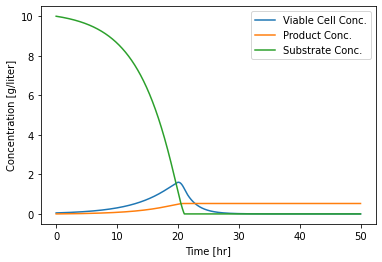

In [105]:

# ADD MEASUREMENT NOISE TO FINAL/Reported DATA  AND  ONLY REPORT 30 MIN MEASUREMENTS TO STUDENTS

if flagBatch == 1:
  IC = [0.05, 0.0, 10.0]
  t = np.linspace(0,50,10000)
  sol = odeint(xdotBatch,IC,t)
  X,P,S = sol.transpose()
  
  plt.plot(t,X)
  plt.plot(t,P)
  plt.plot(t,S)
  
  plt.xlabel('Time [hr]')
  plt.ylabel('Concentration [g/liter]')
  plt.legend(['Viable Cell Conc.',
            'Product Conc.',
            'Substrate Conc.'])
else:
  IC = [0.05, 0.0, 10.0, 1.0]
  t = np.linspace(0,50,10000)
  sol = odeint(xdotFed,IC,t)
  X,P,S,V = sol.transpose()
  plt.plot(t,X)
  plt.plot(t,P)
  plt.plot(t,S)
  plt.plot(t,V)

  plt.xlabel('Time [hr]')
  plt.ylabel('Concentration [g/liter]')
  plt.legend(['Viable Cell Conc.',
            'Product Conc.',
            'Substrate Conc.',
            'Volume [liter]'])

In [106]:
# np.arange(0,10000,1000)
# array([ 1,  2,  3,  4])
ind = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9999]
#S[ind]
P[ind]


array([0.        , 0.0229357 , 0.07937217, 0.21525781, 0.49548868,
       0.52743049, 0.52743049, 0.52743049, 0.52743049, 0.52743049])

<!--NAVIGATION-->
< [Exothermic Continuous Stirred Tank Reactor](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/02.06-Exothermic-CSTR.ipynb) | [Contents](toc.ipynb) | [Model Library](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/02.08-Model-Library.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/02.07-Fed-Batch-Bioreactor.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/02.07-Fed-Batch-Bioreactor.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>